In [12]:
import numpy as np
import pandas as pd
import matplotlib as plt
import talib as ta

In [13]:
data = pd.read_pickle('pickled_5m_bitmex/ETHUSD_5m')
data = data[['timestamp', 'open', 'high', 'low', 'close']]
data.tail()

,timestamp,open,high,low,close
83245,2019-06-15 01:05:00,264.60,264.85,264.00,264.45
83246,2019-06-15 01:10:00,264.45,264.55,264.30,264.35
83247,2019-06-15 01:15:00,264.35,264.90,263.95,264.85
83248,2019-06-15 01:20:00,264.85,264.95,264.55,264.75
83249,2019-06-15 01:25:00,264.75,265.70,264.80,265.45


In [14]:
# Generate the signal 1 or -1 or 0

data['SMA'] = data['close'].rolling(20).mean()

price_above_SMA = data.close > data.SMA
price_below_SMA = data.close < data.SMA

prev_price_above_SMA = data.close.shift(1) > data.SMA.shift(1)
prev_price_below_SMA = data.close.shift(1) < data.SMA.shift(1)

is_green = data.close > data.open
is_red = data.close < data.open

data['signal'] = np.where(prev_price_below_SMA & price_above_SMA, 1, 0)
data['signal'] = np.where(prev_price_above_SMA & price_below_SMA, -1, data.signal)


data = data[['timestamp', 'open', 'high', 'low', 'close', 'signal']]

data['signal'].value_counts()

# IMPORTANT - do I have to shift to avoid future bias? Not sure I do if I'm using market..

 0    72681
 1     5285
-1     5284
Name: signal, dtype: int64

In [15]:
# This is the backtest logic

def backtest_run(_df, _direction, _stop, _tp, _time_in_trade):
    
    trades_list = []
    
    for index, row in _df.iterrows():
        
        if row.signal == 1:
            
            trade_window = _df.iloc[index:index + _time_in_trade].values.tolist()
            
            stop = _stop * trade_window[0][4]
            tp = _tp * trade_window[0][4]
            
           
            for win_row in trade_window:
                
                high = win_row[2]
                low = win_row[3]
                
                trade_row = win_row
                
                if low < stop:
                    trade_result = -1
                    trade_row.append(trade_result)
                    continue
                if high > tp:
                    trade_result = 1
                    trade_row.append(trade_result)
                    continue
                else:
                    trade_result = 0
                    trade_row.append(trade_result)
                    
                
            
            
            trades_list.append(trade_row)
        
        
        if row.signal == -1:
            
            trade_window = _df.iloc[index:index + _time_in_trade].values.tolist()

            stop = (( 1 -_stop) + 1) * trade_window[0][4]
            tp = (2 - _tp) * trade_window[0][4]


            for win_row in trade_window:

                high = win_row[2]
                low = win_row[3]

                trade_row = win_row

                if high > stop:
                    trade_result = -1
                    trade_row.append(trade_result)
                    continue
                if low < tp:
                    trade_result = 1
                    trade_row.append(trade_result)
                    continue
                else:
                    trade_result = 0
                    trade_row.append(trade_result)




            trades_list.append(trade_row)

    return trades_list
    

In [16]:
# Make it smaller for testing purposes
short_data = data

# Run the backtest
trades = backtest_run(short_data, 1, 0.99, 1.013, 20)
trades

[[Timestamp('2018-08-30 05:00:00'), 286.6, 287.25, 286.6, 287.1, 1, 0],
 [Timestamp('2018-08-30 05:05:00'), 287.1, 287.15, 286.85, 287.0, 0, 0],
 [Timestamp('2018-08-30 05:10:00'), 287.0, 286.95, 286.1, 286.65, -1, 0],
 [Timestamp('2018-08-30 05:15:00'), 286.65, 286.7, 286.6, 286.6, 0, 0],
 [Timestamp('2018-08-30 05:30:00'), 286.05, 286.0, 285.3, 285.35, 0, 0],
 [Timestamp('2018-08-30 05:55:00'), 285.0, 284.95, 284.35, 284.55, 0, 0],
 [Timestamp('2018-08-30 06:35:00'), 284.5, 284.5, 283.45, 283.65, 0, -1],
 [Timestamp('2018-08-30 06:45:00'), 282.85, 283.5, 282.65, 283.5, 0, 1],
 [Timestamp('2018-08-30 08:45:00'), 282.55, 282.55, 281.45, 281.95, 0, 0],
 [Timestamp('2018-08-30 08:50:00'), 281.95, 282.05, 280.9, 280.95, 0, 0],
 [Timestamp('2018-08-30 08:55:00'), 280.95, 281.75, 280.65, 281.05, 0, -1],
 [Timestamp('2018-08-30 09:25:00'), 280.65, 280.7, 279.65, 280.25, 0, 1],
 [Timestamp('2018-08-30 12:25:00'), 277.65, 277.9, 277.3, 277.75, 0, 0],
 [Timestamp('2018-08-30 13:00:00'), 276.75,

In [17]:
# Check the amount of signals...
short_data['signal'].value_counts()

 0    72681
 1     5285
-1     5284
Name: signal, dtype: int64

In [18]:
# Does it add up with the length of the data?
len(trades)

10569

Wins: 1067
Losses: 1372
Win rate: 0.43747437474374745
Win size: 1.1499999999999901
Loss size: 1.1500000000000008
RR: 0.9999999999999908


,ts,o,h,l,c,signal,result,pl,cum_pl
10564,2019-06-14 21:40:00,262.15,265.9,262.15,264.50,0,1,12.9985,147.3415
10565,2019-06-15 01:25:00,264.75,265.7,264.80,265.45,0,0,0.0000,147.3415
10566,2019-06-15 01:25:00,264.75,265.7,264.80,265.45,0,0,0.0000,147.3415
10567,2019-06-15 01:25:00,264.75,265.7,264.80,265.45,0,0,0.0000,147.3415
10568,2019-06-15 01:25:00,264.75,265.7,264.80,265.45,0,0,0.0000,147.3415


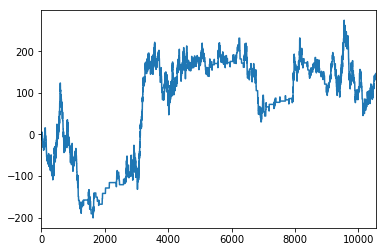

In [26]:
def analyse_results(_trades_list, _fees, _position_size, _stop, _tp):
    
    trades_df = pd.DataFrame(_trades_list, columns=['ts', 'o', 'h', 'l', 'c', 'signal', 'result'])
    
    win = np.where(trades_df.result == 1, 1, 0)
    lose = np.where(trades_df.result == -1, 1, 0)
    
    attempt_trade = np.where(trades_df.signal != 0, 1, 0)
    
    #fees = (_fees * _position_size) * attempt_trade
    
    trades_df['pl'] = np.where(win == 1, ((_position_size * _tp) - _fees) - _position_size, 0)
    trades_df['pl'] = np.where(lose == 1, ((_position_size * _stop) - _fees) - _position_size, trades_df.pl)
    
    trades_df['cum_pl'] = trades_df.pl.cumsum()
    
    
    wins = sum(win)
    losses = sum(lose)
    win_rate = wins/ (wins+losses)
    
    win_size = ((_tp - 1) - _fees) * 100
    loss_size = ((1 - _stop) + _fees) * 100
    RR = win_size/loss_size
    
    print('Wins: ' + str(wins))
    print('Losses: ' + str(losses))
    print('Win rate: ' + str(win_rate))
    print('Win size: ' + str(win_size))
    print('Loss size: ' + str(loss_size))
    print('RR: ' + str(RR))



    
    trades_df.cum_pl.plot()
    
    return trades_df

analysis = analyse_results(trades, 0.0015, 1000, 0.99, 1.013)
analysis.tail()


# NOTE - something is wrong with PL calculation - look at the pl value counts below
# Could it be because of the long decimals of some coins?

In [27]:
analysis['pl'].value_counts()

 0.0000     8130
-10.0015    1372
 12.9985    1067
Name: pl, dtype: int64

In [28]:
# Check for duplicated values. I don't know what caused this problem but it seemed to only be the end 4 rows

trades_to_check = pd.DataFrame(trades)
sum(trades_to_check.duplicated() == True)

3